# 0. Import libraries

In [2]:
import cv2
import mediapipe as mp
import numpy as np
import time as time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import imutils
from pycaret.classification import *
import shutil

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

### Create functions for object detection and pose estimation using mediapipe

In [3]:
# function for object detection using mediapipe
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
# function to draw landmark points and landmark connections using Mediapipe's Pose Estimation
def draw_styled_landmarks(image, results):
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 

In [5]:
# function to calculate angles
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return np.round(angle, 0) 

<img src="https://i.imgur.com/3j8BPdc.png" style="height:300px" >

### Create functions to extract the following angles and keypoints

- **angles**

    - right_elbow
    - right_shoulder
    - right_hip
    - right_knee
    - right_ankle
    
    - left_elbow
    - left_shoulder
    - left_hip
    - left_knee
    - left_ankle
    
- **keypoints (x,y,z coordinates)**

    - right_elbow
    - right_shoulder
    - right_hip
    - right_knee
    - right_ankle
    
    - left_elbow
    - left_shoulder
    - left_hip
    - left_knee
    - left_ankle

# Create function to extract keypoints



In [6]:
# function to extract angles from the joints coordinates which were extracted from the Pose Estimation
def extract_angles(results):

    # JOINTS THAT CORRESPONDS TO MEDIAPIPE NUMBER LABELS
    RW = 16
    RE = 14
    RS = 12
    RH = 24
    RK = 26
    RA = 28
    RFI = 32

    LW = 15
    LE = 13
    LS = 11
    LH = 23
    LK = 25
    LA = 27
    LFI = 31
    
    # Instantiating mediapipe landmark object
    RES = results.pose_landmarks


    # ASSIGNING JOINTS ARRAYS
    RIGHT_WRIST = np.array([RES.landmark[RW].x, RES.landmark[RW].y]) if RES else np.zeros(1*2)
    RIGHT_ELBOW = np.array([RES.landmark[RE].x, RES.landmark[RE].y]) if RES else np.zeros(1*2)
    RIGHT_SHOULDER = np.array([RES.landmark[RS].x, RES.landmark[RS].y]) if RES else np.zeros(1*2)
    RIGHT_HIP = np.array([RES.landmark[RH].x, RES.landmark[RH].y]) if RES else np.zeros(1*2)
    RIGHT_KNEE = np.array([RES.landmark[RK].x, RES.landmark[RK].y]) if RES else np.zeros(1*2)
    RIGHT_ANKLE = np.array([RES.landmark[RA].x, RES.landmark[RA].y]) if RES else np.zeros(1*2)
    RIGHT_FOOT_INDEX = np.array([RES.landmark[RFI].x, RES.landmark[RFI].y]) if RES else np.zeros(1*2)
    
    LEFT_WRIST = np.array([RES.landmark[LW].x, RES.landmark[LW].y]) if RES else np.zeros(1*2)
    LEFT_ELBOW = np.array([RES.landmark[LE].x, RES.landmark[LE].y]) if RES else np.zeros(1*2)
    LEFT_SHOULDER = np.array([RES.landmark[LS].x, RES.landmark[LS].y]) if RES else np.zeros(1*2)
    LEFT_HIP = np.array([RES.landmark[LH].x, RES.landmark[LH].y]) if RES else np.zeros(1*2)
    LEFT_KNEE = np.array([RES.landmark[LK].x, RES.landmark[LK].y]) if RES else np.zeros(1*2)
    LEFT_ANKLE = np.array([RES.landmark[LA].x, RES.landmark[LA].y]) if RES else np.zeros(1*2)
    LEFT_FOOT_INDEX = np.array([RES.landmark[LFI].x, RES.landmark[LFI].y]) if RES else np.zeros(1*2)
    
    # CALCULATING ANGLES FROM JOINTS ARRAYS
    angle_RE = calculate_angle(RIGHT_WRIST, RIGHT_ELBOW, RIGHT_SHOULDER)
    angle_RS = calculate_angle(RIGHT_ELBOW, RIGHT_SHOULDER, RIGHT_HIP)
    angle_RH = calculate_angle(RIGHT_SHOULDER, RIGHT_HIP, RIGHT_KNEE)
    angle_RK = calculate_angle(RIGHT_HIP, RIGHT_KNEE, RIGHT_ANKLE)
    angle_RA = calculate_angle(RIGHT_KNEE, RIGHT_ANKLE, RIGHT_FOOT_INDEX)
    
    angle_LE = calculate_angle(LEFT_WRIST, LEFT_ELBOW, LEFT_SHOULDER)
    angle_LS = calculate_angle(LEFT_ELBOW, LEFT_SHOULDER, LEFT_HIP)
    angle_LH = calculate_angle(LEFT_SHOULDER, LEFT_HIP, LEFT_KNEE)
    angle_LK = calculate_angle(LEFT_HIP, LEFT_KNEE, LEFT_ANKLE)
    angle_LA = calculate_angle(LEFT_KNEE, LEFT_ANKLE, LEFT_FOOT_INDEX)

        
    return np.array([angle_RE, angle_RS, angle_RH, angle_RK, angle_RA,angle_LE, angle_LS, angle_LH, angle_LK, angle_LA])

In [7]:
# Function to extract keypoints from joints coordinates which were extracted from the Pose Estimation
def extract_keypoints(results):    

    # uncomment below if using only non-facial keypoints
    # take only visible joints keypoints (total 16 keypoints 11 to 16 and 23 to 32)
#     pose1 = np.array([[res.x, res.y, res.z] for res in results.pose_landmarks.landmark[11:17]]).flatten() if results.pose_landmarks else np.zeros(6*3)
#     pose2 = np.array([[res.x, res.y, res.z] for res in results.pose_landmarks.landmark[23:33]]).flatten() if results.pose_landmarks else np.zeros(10*3)
#     return np.concatenate([pose1,pose2])

    pose = np.array([[res.x, res.y, res.z] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*3)
    return np.concatenate([pose])

___

In [8]:
# Import dataset from part 2a
df_anglesonly = pd.read_csv('../data/df_anglesonly.csv')

# 4. Modelling

### Instantiating PyCaret
- PRESS ENTER WHEN PROMPTED

In [9]:
# experiment = setup(df.drop(columns='frame_num'), target = 'attack_type', normalize=True)
experiment = setup(df_anglesonly, target = 'attack_type', normalize=True, session_id=42)

best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9512,0.9968,0.9497,0.9514,0.9508,0.9414,0.9416,0.1720
xgboost,Extreme Gradient Boosting,0.9446,0.9960,0.9431,0.9460,0.9443,0.9335,0.9339,1.1580
lightgbm,Light Gradient Boosting Machine,0.9442,0.9965,0.9429,0.9461,0.9440,0.9330,0.9335,3.2760
rf,Random Forest Classifier,0.9438,0.9959,0.9424,0.9441,0.9434,0.9325,0.9327,0.2030
knn,K Neighbors Classifier,0.9351,0.9873,0.9337,0.9359,0.9349,0.9221,0.9223,0.0490
gbc,Gradient Boosting Classifier,0.9330,0.9935,0.9314,0.9336,0.9327,0.9196,0.9199,0.4200
dt,Decision Tree Classifier,0.9190,0.9538,0.9172,0.9199,0.9185,0.9027,0.9031,0.0060
qda,Quadratic Discriminant Analysis,0.8809,0.9739,0.8791,0.8846,0.8809,0.8571,0.8579,0.0050
lr,Logistic Regression,0.8499,0.9676,0.8471,0.8522,0.8495,0.8199,0.8205,0.2550
lda,Linear Discriminant Analysis,0.8272,0.9595,0.8260,0.8311,0.8246,0.7926,0.7943,0.0050


### Create model

In [10]:
et = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9339,0.9930,0.9303,0.9341,0.9327,0.9206,0.9211
1,0.9504,0.9982,0.9492,0.9506,0.9503,0.9405,0.9405
2,0.9545,0.9986,0.9539,0.9549,0.9546,0.9454,0.9455
3,0.9339,0.9945,0.9312,0.9334,0.9332,0.9206,0.9208
4,0.9669,0.9984,0.9670,0.9679,0.9665,0.9603,0.9607
5,0.9463,0.9968,0.9444,0.9469,0.9459,0.9355,0.9358
6,0.9545,0.9969,0.9527,0.9542,0.9540,0.9454,0.9456
7,0.9545,0.9971,0.9535,0.9543,0.9543,0.9454,0.9455
8,0.9752,0.9995,0.9748,0.9756,0.9753,0.9702,0.9703
9,0.9419,0.9952,0.9406,0.9421,0.9416,0.9303,0.9304


### Tune model

In [11]:
tuned_et = tune_model(et, choose_better= True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8884,0.9838,0.8861,0.8946,0.8855,0.8661,0.8683
1,0.8967,0.9921,0.8960,0.9007,0.8943,0.8760,0.8776
2,0.9050,0.9929,0.9034,0.9094,0.9049,0.8860,0.8869
3,0.8884,0.9876,0.8857,0.8852,0.8852,0.8661,0.8667
4,0.8678,0.9874,0.8658,0.8669,0.8612,0.8413,0.8433
5,0.9008,0.9909,0.8975,0.9019,0.9003,0.8810,0.8814
6,0.8926,0.9893,0.8915,0.9019,0.8885,0.8711,0.8742
7,0.8843,0.9905,0.8823,0.8831,0.8822,0.8611,0.8618
8,0.9174,0.9956,0.9165,0.9239,0.9167,0.9008,0.9025
9,0.8589,0.9824,0.8565,0.8646,0.8530,0.8308,0.8345


### Predict on hold-out test

In [12]:
predict_model(et)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9344,0.9956,0.9380,0.9355,0.9345,0.9212,0.9214


,right_elbow_angle,right_shoulder_angle,right_hip_angle,right_knee_angle,right_ankle_angle,left_elbow_angle,left_shoulder_angle,left_hip_angle,left_knee_angle,left_ankle_angle,attack_type,Label,Score
0,0.245572,-0.274445,0.856269,0.182110,0.689336,1.115803,-0.841481,-0.730720,0.042572,-0.668841,3,3,1.00
1,-1.340647,-0.274445,1.004427,-0.237894,0.851501,0.346575,-0.003924,-1.613119,-0.009048,-1.368736,0,3,0.35
2,0.984606,0.335074,-1.909337,-2.037911,-1.297188,-0.291321,-0.590214,0.372279,0.352289,0.186587,0,0,0.78
3,1.092758,1.670208,0.510569,0.782116,1.216373,-1.567114,-0.869400,-0.041345,-0.938200,1.003132,4,4,0.97
4,0.407799,-0.100296,0.757498,-0.237894,-0.932316,0.628000,0.359017,-0.841020,-1.041439,-1.718684,3,3,0.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032,-1.070269,-0.477617,0.782191,0.662114,1.013667,-1.642160,0.917389,0.041380,0.662006,-0.124477,3,3,0.32
1033,-1.665101,-0.506642,0.955041,-0.297894,0.202841,0.327813,0.051913,-0.565270,-0.834961,-1.096555,3,3,1.00
1034,0.822379,-0.448593,-1.785872,-0.177893,-0.202572,-0.704078,-0.394784,-0.206795,0.662006,0.342120,0,0,0.98
1035,0.912505,2.482899,0.634033,0.362112,0.486630,-2.129963,-0.255191,0.648029,0.507148,1.158665,4,4,1.00


### Evaluate model

In [13]:
evaluate_model(et)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

- The most important angles in differentiating strikes are angles related to hips and shoulders. This may suggest fighters to focus more on the techniques in relation to these angles.
- The Confusion Matrix shows that the model is highly accurate on the test set as shown also by the metrics shown above.

### Interpret model

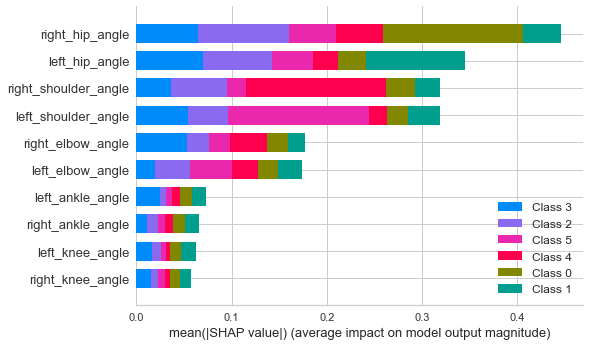

In [14]:
interpret_model(et)

### Save model

In [15]:
save_model(et, 'saved_et_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='attack_type', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_...
                  ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nod

### Load model

In [16]:
saved_lr = load_model('saved_et_model')

Transformation Pipeline and Model Successfully Loaded


In [17]:
saved_lr

Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[],
                                      target='attack_type', time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_...
                 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                      class_weight=None, criterion='gini',
                                      max_depth=None, max_features='auto',
                                      max_leaf_nodes=None, max_samp

### Finalize model

In [18]:
final_model = finalize_model(et)
qda = create_model('qda')
lr = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8182,0.9639,0.8146,0.8237,0.8187,0.7818,0.7827
1,0.8719,0.9642,0.8703,0.8719,0.8704,0.8462,0.8468
2,0.8636,0.9650,0.8603,0.8678,0.8652,0.8364,0.8366
3,0.8554,0.9581,0.8515,0.8536,0.8537,0.8264,0.8267
4,0.8471,0.9631,0.8457,0.8480,0.8452,0.8165,0.8174
5,0.8595,0.9821,0.8554,0.8582,0.8573,0.8313,0.8319
6,0.8264,0.9654,0.8242,0.8262,0.8248,0.7917,0.7923
7,0.8554,0.9721,0.8534,0.8579,0.8548,0.8264,0.8272
8,0.9132,0.9867,0.9124,0.9186,0.9139,0.8959,0.8967
9,0.7884,0.9558,0.7833,0.7956,0.7912,0.7461,0.7465


# 4.1 Predicting on unseen video / webcam

### Create function to convert extracted keypoints/angles into dataframe for prediction of new data (video footage or webcam)

In [19]:
def convert_df(keypoints_angles, num_frame):
    # instantiate new_data
    new_data = pd.DataFrame(keypoints_angles)
    # convert new_data dataframe column name to fit into model 
    new_data_df = new_data.T
    new_data_df.insert(0, 'frame_num', num_frame)
    predicted_full_list = ['frame_num'] + keypoints_list_3d + angle_joints_list
    new_data_df.columns = predicted_full_list
    new_data_df = new_data_df.astype({'frame_num':int})
    
    return new_data_df

def convert_df_anglesonly(angles, num_frame):
    new_data = pd.DataFrame(angles).T
    new_data.columns = angle_joints_list
    return new_data


- Predict using `extratreesclassifier` model: higher accuracy but lower speed/latency
- Predict using `logisticregression` / `qda` model: lower accuracy but higher speed/latency

In [55]:
# uncomment the below to select the models to be used 
final_model_predict = final_model
# final_model_predict = qda
# final_model_predict = lr

# uncomment the below to select the type of video to be used 
path = 0 # for webcam
# path = '../asset/predict_7_moving.mp4' # for unseen data in `asset` folder

cap = cv2.VideoCapture(path)
# instantiating variables to collect keypoints/angles data and prediction data
df_predicted_frames = pd.DataFrame()
df_collated_keypoints = pd.DataFrame()
num_frame = 0 # keeps track of number of frames
score_tracker = []
actions = np.array(['right_highkick','left_highkick','right_lowkick','left_lowkick','right_punch','left_punch'])

angle_joints_list = ['right_elbow_angle', 'right_shoulder_angle', 'right_hip_angle', 'right_knee_angle', 
                     'right_ankle_angle', 'left_elbow_angle', 'left_shoulder_angle', 'left_hip_angle', 
                     'left_knee_angle', 'left_ankle_angle']

# Set mediapipe model 
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        if frame is None:
            break

        
        if ret:
            ## 1. Preprocessing of input frames (frame by frame)
            # Make detections
            image, results = mediapipe_detection(frame, pose)
            # Draw landmarks
            draw_styled_landmarks(image, results)
            # Extracting angles only
            angles = extract_angles(results) # extract 10 angles

            ## 2. Converting extracted keypoints/angles into dataframe
            # function to return dataframe of each instant frame
            new_data_df = convert_df_anglesonly(angles, num_frame)
        
            ## 3. Conduct prediction on each frame
            # predict instantaneous frame ==> predict_model() returns dataframe with predicted results
            
            # CHANGE THE MODEL BELOW AS NEEDED
            res  = predict_model(final_model_predict, data = new_data_df)
            if res['Score'][0] > 0.60:
                action_index = res['Label'][0] # get the predicted action
                score_tracker.append(action_index)
                if len(score_tracker) >=3:
                    score_tracker = score_tracker[-3:]
                    if len(set(score_tracker)) ==1:
                        print(actions[action_index])
                        cv2.rectangle(image, (0,0), (340, 200), (245, 117, 16), -1)
                        cv2.putText(image, str(actions[action_index])+str(np.round((res['Score'][0]*100),1)), (60,100), 
                                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                        
                    elif len(set(score_tracker)) !=1:
                        cv2.rectangle(image, (0,0), (340, 200), (230, 230, 230), -1)
#                         cv2.putText(image, str(actions[action_index])+str(res['Score'][0]), (3,30), 
#                                        cv2.FONT_HERSHEY_SIMPLEX, 1, (105,105,105), 2, cv2.LINE_AA)
                        cv2.putText(image, 'neutral', (60,100), 
                                       cv2.FONT_HERSHEY_SIMPLEX, 1, (105,105,105), 2, cv2.LINE_AA)


                        
            elif res['Score'][0] <= 0.6:
                action_index = res['Label'][0] # get the predicted action
                cv2.rectangle(image, (0,0), (340, 200), (230, 230, 230), -1)
#                 cv2.putText(image, str(actions[action_index])+str(res['Score'][0]), (3,30), 
#                                cv2.FONT_HERSHEY_SIMPLEX, 1, (105,105,105), 2, cv2.LINE_AA)
                cv2.putText(image, 'neutral', (60,100), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (105,105,105), 2, cv2.LINE_AA)

            # 4. Show pose estimation and prediction on screen
#             image = cv2.resize(image, (960,540))
            cv2.imshow('OpenCV Feed', image)
            num_frame+=1
#         else:
#             cap.release()
#             break
            
        # Break
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1)

In [ ]:
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)